<div style="display: flex; align-items: center; justify-content: space-between; border-bottom: 3px solid #D0D0D0; padding: 10px; font-family: Arial, sans-serif;">
  <!-- Logo -->
  <img src="https://upload.wikimedia.org/wikipedia/commons/1/1c/Uoc_masterbrand_vertical.png" alt="Logo" style="width: 150px; height: auto;">

  <!-- Detalles -->
  <div style="text-align: right; line-height: 1.6; margin-left: 20px; margin-right: 80px">
    <p style="margin: 0; font-size: 1.2em; font-weight: bold; color: #333;">Proyecto: <span style="color: #878787;">Práctica - Parte 2</span></p>
    <p style="margin: 0; font-size: 1em; font-weight: bold; color: #333;">Notebook: <span style="color: #878787;">Exploración inicial de datos de </span></p>
    <p style="color: #878787;">Juan Luis González Rodríguez - Visualización de datos</span></p>
  </div>
</div>

# 0. Librerías

In [82]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import shapiro, wilcoxon
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# 1.Exploración y limpieza de datos

Cada individuo ha de tener 2 registros, uno para la toma de la muestra antes de dormir y otro para la toma de la muestra al despertar. Tenga en cuenta que para el usuario 1 con 2 ciclos de sueño, la muestra inicial se toma antes de dormir en el primer ciclo, y la muestra al despertarse tras levantarse en el segundo ciclo.

In [83]:
# Creamos un df vacio
df_salivas = pd.DataFrame()

# Obtenemos la lista con los paths de los archivos
data_path = os.path.join('..', '0_data', 'MMASH')
csv_files = [os.path.join(root, file) for root, _, files in os.walk(data_path) for file in files if file.endswith('saliva.csv')]

# Iteramos sobre los archivos
for file in csv_files:
    # Leemos el archivo
    df = pd.read_csv(file, usecols=lambda column: column != 'Unnamed: 0')
    # Extraemos el identificador del usuario del nombre del fichero
    user_id = os.path.basename(os.path.dirname(file))
    # Añadimos la columna 'User' al dataframe
    df['User'] = user_id
    # Concatenamos el df al df principal
    df_salivas = pd.concat([df_salivas, df])

# Ordenamos el df por el numero del usuario
df_salivas['User_num'] = df_salivas['User'].str.extract('(\d+)').astype(int)
df_salivas.sort_values(by='User_num', inplace=True)
df_salivas.drop(columns='User_num', inplace=True)

# Visualizamos el df
df_salivas.info()
display(df_salivas.head())

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 0 to 1
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SAMPLES         42 non-null     object 
 1   Cortisol NORM   42 non-null     float64
 2   Melatonin NORM  42 non-null     float64
 3   User            42 non-null     object 
dtypes: float64(2), object(2)
memory usage: 1.6+ KB


,SAMPLES,Cortisol NORM,Melatonin NORM,User
0,before sleep,0.034137,1.738385e-08,user_1
1,wake up,0.077939,6.747893e-09,user_1
0,before sleep,0.021186,1.676342e-08,user_2
1,wake up,0.261252,2.853905e-08,user_2
0,before sleep,0.012142,5.714439e-09,user_3


Se comprueba que cada usuario tiene 2 registros con una muestra antes de dormir y otra al despertar.

In [84]:
def check_user_records(df):
    """
    Esta función comprueba que cada usuario tenga dos registros,
    uno para antes de dormir y otro para al despertar.
    
    Args:
    df: DataFrame con los datos de los usuarios.
    
    Returns:
    None
    """
    users = df['User'].unique()
    for user in users:
        user_data = df[df['User'] == user]
        if len(user_data) != 2 or 'before sleep' not in user_data['SAMPLES'].values or 'wake up' not in user_data['SAMPLES'].values:
            print(f"El usuario {user} no tiene el número correcto de registros.")
        else:
            print(f"El usuario {user} tiene el número correcto de registros.")

check_user_records(df_salivas)
# Obtener los usuarios de los nombres de las carpetas
usuarios_carpetas = os.listdir(data_path)

# Comprobar que los usuarios de las carpetas están en el dataframe
usuarios_df = df_salivas['User'].unique()

usuarios_faltantes = set(usuarios_carpetas) - set(usuarios_df)
if usuarios_faltantes:
    print(f"Los siguientes usuarios están en las carpetas pero no en el dataframe: {usuarios_faltantes}")
else:
    print("Todos los usuarios de las carpetas están presentes en el dataframe.")

El usuario user_1 tiene el número correcto de registros.
El usuario user_2 tiene el número correcto de registros.
El usuario user_3 tiene el número correcto de registros.
El usuario user_4 tiene el número correcto de registros.
El usuario user_5 tiene el número correcto de registros.
El usuario user_6 tiene el número correcto de registros.
El usuario user_7 tiene el número correcto de registros.
El usuario user_8 tiene el número correcto de registros.
El usuario user_9 tiene el número correcto de registros.
El usuario user_10 tiene el número correcto de registros.
El usuario user_11 tiene el número correcto de registros.
El usuario user_12 tiene el número correcto de registros.
El usuario user_13 tiene el número correcto de registros.
El usuario user_14 tiene el número correcto de registros.
El usuario user_15 tiene el número correcto de registros.
El usuario user_16 tiene el número correcto de registros.
El usuario user_17 tiene el número correcto de registros.
El usuario user_18 tien

El *usuario 21* no tiene ningún registro de saliva. Según los autores [1], esto se debe a un problema en la recogida de muestras. No imputaremos esos valores y no consideraremos los datos de este usuario para el análisis.

**Cortisol NORM**

Los niveles de cortisol están en μg de cortisol por 100 μg de proteína. Los niveles altos de cortisol en saliva se asocian con una peor calidad y menor eficiencia del sueño [2]. También hay estudios que indican que una mayor variación en los niveles de cortisol antes de dormir y al despertar en adultos mayores se asocia a una mejor calidad subjetiva del sueño [3]. Realizaremos estas comprobaciones cuando crucemos los datos del saliva.csv y de sleep.csv

A continuación, analizaremos los niveles y la distribución del cortisol en el dataframe. Se creará una nueva variable que permitirá medir la variación de niveles de cortisol entre antes de dormir y al despertar.

In [85]:
# Se calculan los estadísticos descriptivos
df_salivas['Cortisol NORM'].describe()

count    42.000000
mean      0.048957
std       0.047772
min       0.012017
25%       0.019507
50%       0.034649
75%       0.061437
max       0.261252
Name: Cortisol NORM, dtype: float64

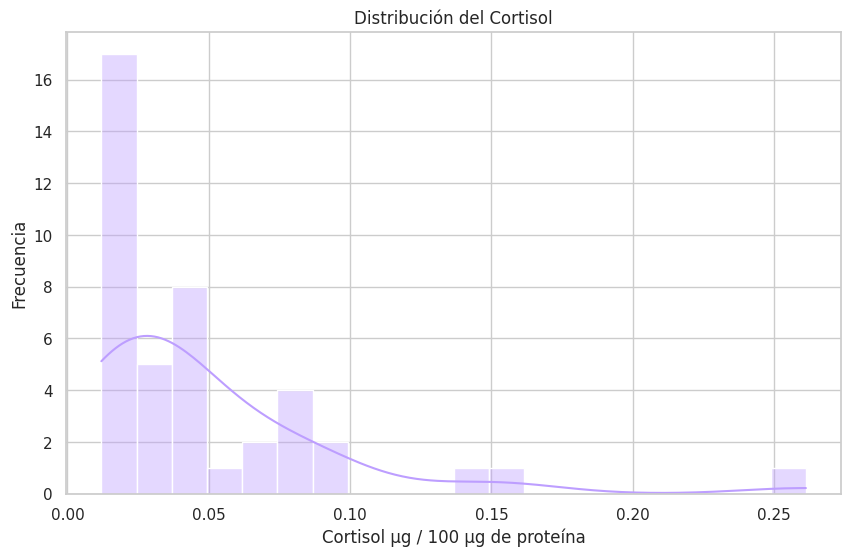

In [86]:
# Configuramos el estilo de los gráficos
sns.set_theme(style="whitegrid")

# Creamos para cortisol
plt.figure(figsize=(10, 6))
sns.histplot(df_salivas['Cortisol NORM'], bins=20, kde=True, color='#BD9EFF', alpha=0.4)
plt.title('Distribución del Cortisol')
plt.xlabel('Cortisol μg / 100 μg de proteína')
plt.ylabel('Frecuencia')
plt.show()

Vemos que los niveles de cortisol suelen estar en un rango de valores entre 0.01 y 0.10 μg / 100 μg de proteína. Sin embargo, hay algunos casos atípicos en torno a los 0.15 y 0.25 μg / 100 μg de proteína. A continuación, se identificarán estos casos para posteriormente estudiar cómo afectan al sueño.

In [87]:
# Identificar casos atípicos
outliers = df_salivas[(df_salivas['Cortisol NORM'] > 0.10) & (df_salivas['Cortisol NORM'] < 0.15) | (df_salivas['Cortisol NORM'] > 0.15)]

# obtenemos los usuarios con valores atípicos
outliers_users = outliers['User'].unique()

# Visualizamos los niveles de cortisol de los usuarios con valores atípicos
df_outliers = df_salivas[df_salivas['User'].isin(outliers_users)]
df_outliers

,SAMPLES,Cortisol NORM,Melatonin NORM,User
0,before sleep,0.021186,1.676342e-08,user_2
1,wake up,0.261252,2.853905e-08,user_2
0,before sleep,0.155777,3.542804e-09,user_12
1,wake up,0.145431,8.639988e-09,user_12


Se observa que el valor superior a 0.25 es del *usuario 2*, pero este valor es el valor del usuario al despertarse (además de que tiene unos valores bajos al dormirse), por lo que al haber una gran variación entre los niveles al dormir y al despertarse, en principio se presupone un buen indicador de calidad de sueño subjetiva. Mientras que los valores del *usuario 12* son valores relativamente altos al despertarse y al acostarse (respecto al resto de participantes), con muy poca variabilidad, lo que sugiere que la calidad subjetiva del sueño de este usuario debe ser mucho peor. Esto nos lleva a explorar cuáles son las distribuciones de los niveles de cortisol si separamos por los instantes de antes de irse a la cama y los de despertarse.

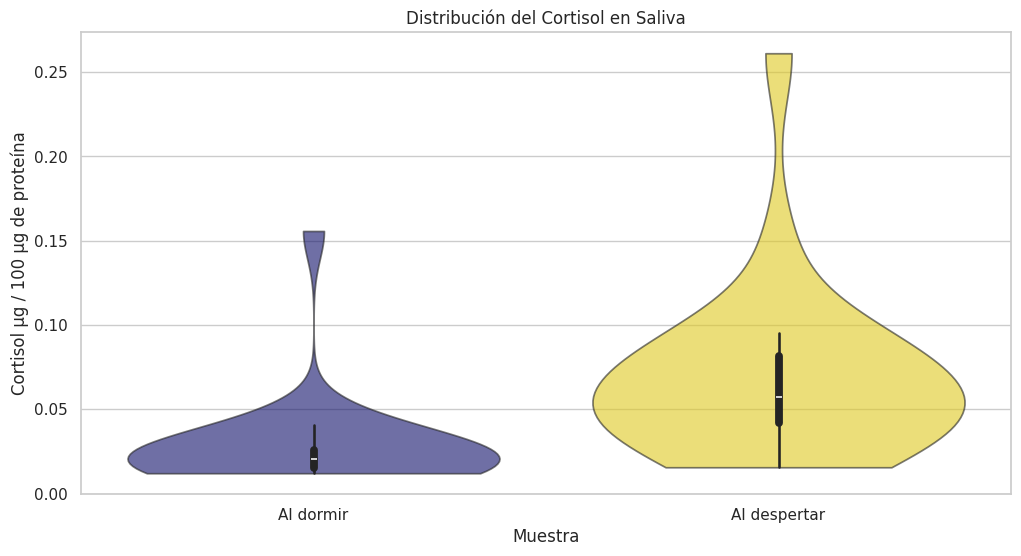

In [88]:
# Configuramos el estilo de los gráficos
sns.set_theme(style="whitegrid")

# Se crea un violin plot para visualizar la distribución del cortisol en saliva en función de la toma de la muestra
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_salivas, x='SAMPLES', y='Cortisol NORM', hue='SAMPLES', palette=['#000078', '#FFE000'], alpha=0.6, inner='box', cut=0)
plt.title('Distribución del Cortisol en Saliva')
plt.xlabel('Muestra')
plt.ylabel('Cortisol μg / 100 μg de proteína')
plt.xticks(ticks=[0, 1], labels=['Al dormir', 'Al despertar'])
plt.show()

Se observa que los valores de cortisol en saliva están más dispersos en la muestra tomada al despertar que en la muestra tomada al dormir. Además, la mediana del cortisol en saliva es mayor en la muestra tomada al despertar que en la muestra tomada al dormir, lo cual es consistente con la variación normal de cortisol durante el sueño. En ambos casos se observa una asimetría en los valores altos de cortisol, tal y como se observaba en el histograma.

Realizaremos una prueba estadística para comprobar si hay diferencias significativas en los niveles de cortisol en saliva entre las muestras tomadas al dormir y al despertar. Para ello, primero calcularemos si las muestras siguen una distribución normal (aunque gráficamente ya se puede observar que no es así). Como tenemos menos de 30 muestras en cada grupo, utilizaremos el test de normalidad de Shapiro-Wilk.

In [89]:
# Se separan los datos de cortisol en función de la toma de la muestra
cortisol_before_sleep = df_salivas[df_salivas['SAMPLES'] == 'before sleep']['Cortisol NORM']
cortisol_wake_up = df_salivas[df_salivas['SAMPLES'] == 'wake up']['Cortisol NORM']

# Se realiza el test de normalidad de Shapiro-Wilk
stat_before_sleep, p_before_sleep = shapiro(cortisol_before_sleep)
stat_wake_up, p_wake_up = shapiro(cortisol_wake_up)

# Se imprimen los resultados
print(f"Antes de dormir: Estadístico={stat_before_sleep}, p-value={p_before_sleep}")
print(f"Al despertar: Estadístico={stat_wake_up}, p-value={p_wake_up}")

Antes de dormir: Estadístico=0.4669133671185869, p-value=1.0220080022304207e-07
Al despertar: Estadístico=0.7389550835127663, p-value=8.777160782498023e-05


Como los *p-values* son menores a 0.05, se rechaza la hipótesis nula de que los datos siguen una distribución normal. Por lo tanto, se utilizará el test de Wilcoxon para comparar los niveles de cortisol antes de dormir y al despertar.

In [90]:
# Se realiza el test de Wilcoxon
stat, p = wilcoxon(cortisol_before_sleep, cortisol_wake_up)

# Se imprimen los resultados
print(f"Estadístico={stat}, p-value={p}")

# SI el p-valor es menor que 0.05, se rechaza la hipótesis nula
if p < 0.05:
    print("Se rechaza la hipótesis nula. Hay diferencias significativas entre los niveles de cortisol antes de dormir y al despertar.")
else:
    print("No se rechaza la hipótesis nula. No hay diferencias significativas entre los niveles de cortisol antes de dormir y al despertar.")

Estadístico=13.0, p-value=8.392333984375e-05
Se rechaza la hipótesis nula. Hay diferencias significativas entre los niveles de cortisol antes de dormir y al despertar.


Como se observa en el test de Wilcoxon (un test no paramétrico), el p-valor es menor que 0.05, por lo que se rechaza la hipótesis nula. Esto significa que hay diferencias significativas entre los niveles de cortisol antes de dormir y al despertar. Tal y como se aprercia en el gráfico de violín, los niveles de cortisol son más altos al despertar que antes de dormir.

Por último, calcularemos la variación del cortisol en saliva entre la toma de la muestra antes de dormir y al despertar. Para ello, determinaremos la diferencia entre los niveles de cortisol al despertar y antes de dormir para cada usuario, y visualizaremos la distribución de estas diferencias. Valores positivos indicarán un aumento en los niveles de cortisol al despertar, mientras que valores negativos indicarán una disminución a lo largo de la noche.

,User,Cortisol_diff
0,user_1,0.043802
1,user_2,0.240065
2,user_3,0.031657
3,user_4,0.017952
4,user_5,0.067206
5,user_6,0.066849
6,user_7,0.036868
7,user_8,0.051331
8,user_9,0.054592
9,user_10,-0.017387


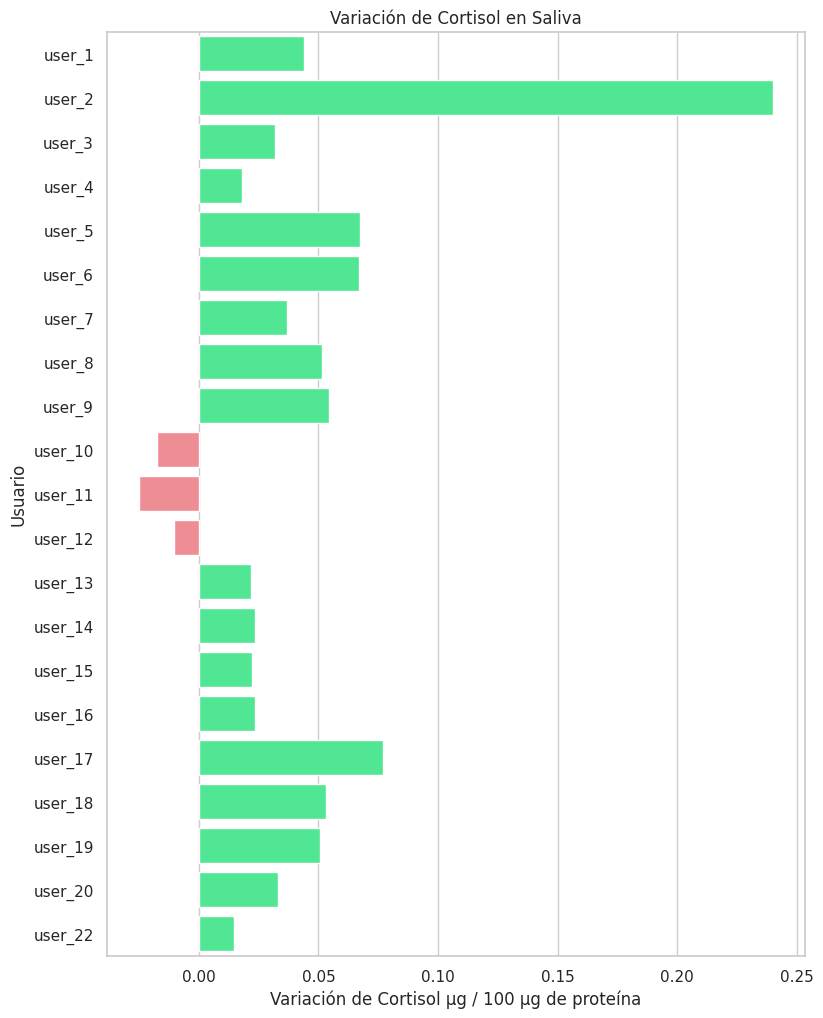

In [91]:
def get_hormon_diff(user, hormone_column):
    """
    Esta función calcula la diferencia entre los niveles de una hormona al despertar y antes de dormir de un usuario.
    Para ello, se pasa como argumento el identificador del usuario y la columna de la hormona.
    
    Args:
    user: Identificador del usuario.
    hormone_column: Columna de la hormona a analizar.
    
    Returns:
    Diferencia entre los niveles de la hormona al despertar y antes de dormir.
    """
    try:
        if user not in df_salivas['User'].unique():
            print(f"El usuario {user} no existe en el dataframe.")
            return None
        hormone_before_sleep = df_salivas[(df_salivas['User'] == user) & (df_salivas['SAMPLES'] == 'before sleep')][hormone_column].values[0]
        hormone_wake_up = df_salivas[(df_salivas['User'] == user) & (df_salivas['SAMPLES'] == 'wake up')][hormone_column].values[0]
    except IndexError:
        print(f"El usuario {user} no tiene uno de los dos valores necesarios.")
        return None

    hormone_diff = hormone_wake_up - hormone_before_sleep

    return hormone_diff

# Creamos un df con la una columna con el id de cada usuario con valores de saliva disponibles
df_saliva_diff = pd.DataFrame(df_salivas['User'].unique(), columns=['User'])

# Calculamos la diferencia de cortisol para cada usuario
df_saliva_diff['Cortisol_diff'] = df_saliva_diff['User'].apply(lambda x: get_hormon_diff(x, 'Cortisol NORM'))
display(df_saliva_diff)

# Se plotea un gráfico de barras con las variaciones por usuario girado 90º
plt.figure(figsize=(9, 12))
sns.barplot(data=df_saliva_diff, x='Cortisol_diff', y='User', orient='h', hue='User',
            palette=['#FF7D87' if x < 0 else '#38FF90' for x in df_saliva_diff['Cortisol_diff']])
plt.title('Variación de Cortisol en Saliva')
plt.xlabel('Variación de Cortisol μg / 100 μg de proteína')
plt.ylabel('Usuario')
plt.show()


Se observa que, salvo los usuarios 10, 11 y 12, el resto de los usuarios presentan un aumento en los niveles de cortisol al despertar respecto a los niveles antes de dormir. Exploraremos otros métodos de visualización para analizar estos datos visualmente, como un gráfico de dispersión conectado con los valores absolutos y otro con los valores normalizados. Será importante no solo mostrar si aumenta o disminuye, sino también la magnitud, ya que puede ser un buen predictor de la calidad y eficiencia del sueño.

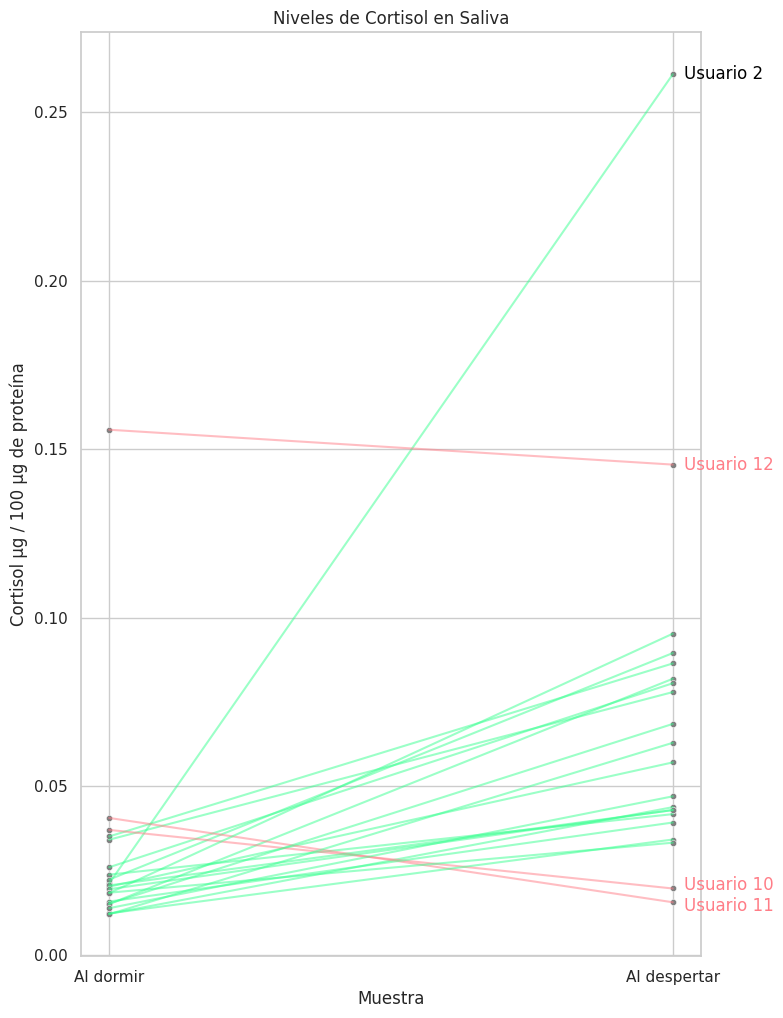

In [92]:
def pretty_user_text(user):
    """
    Esta función formatea el texto del identificador de un usuario para que sea más legible.
    
    Args:
    user: Identificador del usuario.
    
    Returns:
    Identificador del usuario formateado.
    """
    user = user.replace('user_', 'Usuario ')
    return user

df_temp = pd.DataFrame({
    'User': df_saliva_diff['User'],
    'Cortisol_before_sleep': cortisol_before_sleep.values,
    'Cortisol_wake_up': cortisol_wake_up.values
})

# Crear un gráfico de dispersión conectado con los niveles de cortisol de cada usuario antes de dormir y al despertar
plt.figure(figsize=(8, 12))

# Dibujar los puntos de antes de dormir y al despertar
sns.scatterplot(x=[0]*len(df_temp), y=df_temp['Cortisol_before_sleep'], color='gray',s=20, legend=False)
sns.scatterplot(x=[1]*len(df_temp), y=df_temp['Cortisol_wake_up'], color='gray', s=20, legend=False)

# Conectar los puntos con colores específicos
for i in range(len(df_temp)):
    if df_temp['Cortisol_wake_up'].iloc[i] > df_temp['Cortisol_before_sleep'].iloc[i]:
        color = '#38FF90'
    elif df_temp['Cortisol_wake_up'].iloc[i] < df_temp['Cortisol_before_sleep'].iloc[i]:
        color = '#FF7D87'
    else:
        color = 'gray'
    plt.plot([0, 1], [df_temp['Cortisol_before_sleep'].iloc[i], df_temp['Cortisol_wake_up'].iloc[i]], color=color, alpha=0.5)

plt.title('Niveles de Cortisol en Saliva')
plt.xlabel('Muestra')
plt.ylabel('Cortisol μg / 100 μg de proteína')
plt.xticks(ticks=[0, 1], labels=['Al dormir', 'Al despertar'])

# añade un texto a los usuarios con variaciones negativas para identificarlos a la derecha de los puntos de al despertar
for i in range(len(df_temp)):
    user_pretty = pretty_user_text(df_temp['User'].iloc[i])
    y_value = df_temp['Cortisol_wake_up'].iloc[i]
    if df_temp['User'].iloc[i] == 'user_10':
        y_value += 0.001
    elif df_temp['User'].iloc[i] == 'user_11':
        y_value -= 0.001
    if df_temp['Cortisol_wake_up'].iloc[i] < df_temp['Cortisol_before_sleep'].iloc[i]:
        plt.text(1.02, y_value, user_pretty, ha='left', va='center', color='#FF7D87')
    # si la variación tiene una diferencia mayor a 0.15, se añade un texto a la derecha de los puntos de al despertar
    if abs(df_temp['Cortisol_wake_up'].iloc[i] - df_temp['Cortisol_before_sleep'].iloc[i]) > 0.15:
        plt.text(1.02, y_value, user_pretty, ha='left', va='center', color='black')


plt.show()


Se advierte que los usuarios 10, 11 y 12 tienen niveles de cortisol al despertar menores que los niveles de cortisol antes de dormir, lo cual no es común en los demás usuarios, quienes experimentan una subida de 0.04 μg / 100 μg de proteína en promedio. También es muy interesante señalar que el usuario 2 experimenta una subida de cortisol de 0.24 μg / 100 μg de proteína, lo cual es una subida muy significativa y habrá que analizar en detalle los datos de sueño de este usuario para ver si hay alguna relación.

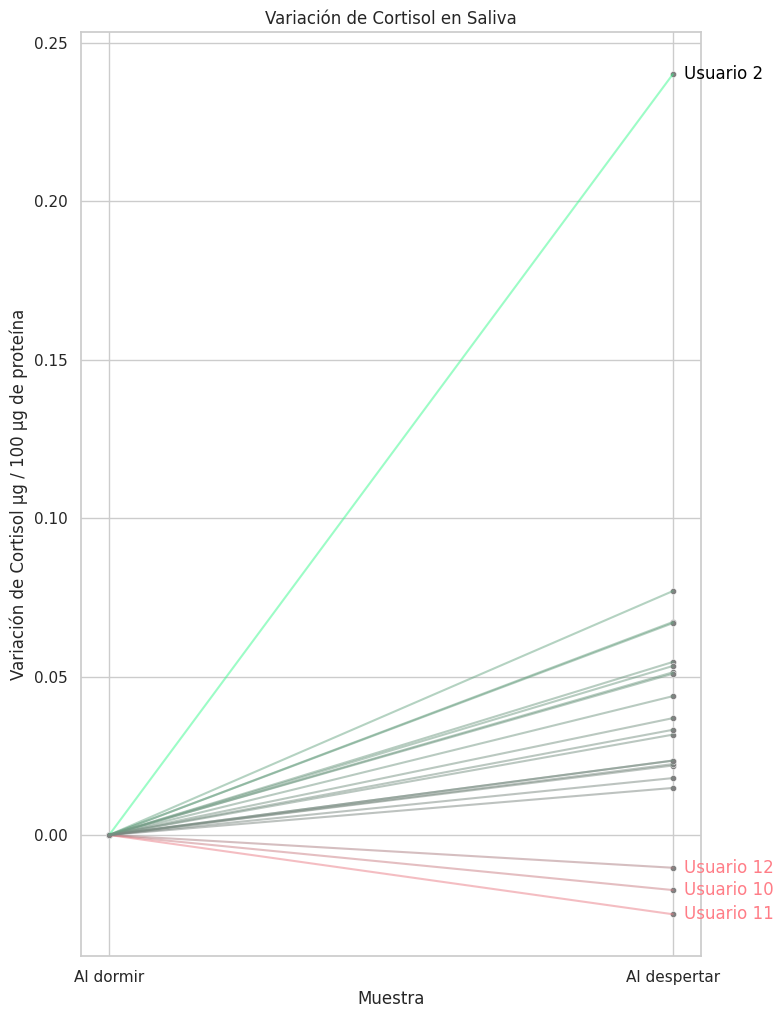

In [93]:
# Crear un df con los datos de cortisol de antes de dormir y al despertar
df_temp_norm = pd.DataFrame({
    'User': df_saliva_diff['User'],
    'Cortisol_before_sleep': cortisol_before_sleep.values,
    'Cortisol_wake_up': cortisol_wake_up.values
})

# Normalizar los valores de cortisol
df_temp_norm['Cortisol_wake_up_norm'] = df_temp_norm['Cortisol_wake_up'] - df_temp_norm['Cortisol_before_sleep']
df_temp_norm['Cortisol_before_sleep'] = 0

# Crear el gráfico de dispersión conectado con los niveles de cortisol normalizados
plt.figure(figsize=(8, 12))

# Dibujar los puntos de antes de dormir y al despertar
sns.scatterplot(x=[0]*len(df_temp_norm), y=df_temp_norm['Cortisol_before_sleep'], color='gray', s=20, legend=False)
sns.scatterplot(x=[1]*len(df_temp_norm), y=df_temp_norm['Cortisol_wake_up_norm'], color='gray', s=20, legend=False)

# Definir los colores personalizados
colors = ['#FF7D87', 'gray', '#38FF90']
cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)
norm = TwoSlopeNorm(vmin=-0.03, vcenter=0, vmax=0.25)

# Conectar los puntos con colores específicos
for i in range(len(df_temp_norm)):
    color = cmap(norm(df_temp_norm['Cortisol_wake_up_norm'].iloc[i]))
    plt.plot([0, 1], [df_temp_norm['Cortisol_before_sleep'].iloc[i], df_temp_norm['Cortisol_wake_up_norm'].iloc[i]], color=color, alpha=0.5)

plt.title('Variación de Cortisol en Saliva')
plt.xlabel('Muestra')
plt.ylabel('Variación de Cortisol μg / 100 μg de proteína')
plt.xticks(ticks=[0, 1], labels=['Al dormir', 'Al despertar'])

# Añadir un texto a los usuarios con variaciones negativas para identificarlos a la derecha de los puntos de al despertar
for i in range(len(df_temp_norm)):
    user_pretty = pretty_user_text(df_temp_norm['User'].iloc[i])
    y_value = df_temp_norm['Cortisol_wake_up_norm'].iloc[i]
    if df_temp_norm['Cortisol_wake_up_norm'].iloc[i] < 0:
        plt.text(1.02, y_value, user_pretty, ha='left', va='center', color='#FF7D87')
    # Si la variación tiene una diferencia mayor a 0.15, se añade un texto a la derecha de los puntos de al despertar
    if abs(df_temp_norm['Cortisol_wake_up_norm'].iloc[i]) > 0.15:
        plt.text(1.02, y_value, user_pretty, ha='left', va='center', color='black')

plt.show()


Esta versión del gráfico es más clara y permite visualizar de manera más sencilla las variaciones de cortisol en saliva de los usuarios, aunque se pierde la información de los valores absolutos de cortisol antes de dormir y al despertar. Son los valores relativos los que nos interesan en este caso, por lo que considero que es una representación más adecuada. Además, el uso de la gradación de color permite codifical de una manera rápida y visual determinar la relación entre color y crecimiento.

**Melatonin NORM**

Al igual que para el cortisol, analizaremos la distribución general de melatonina. Esta se mide en μg de melatonina por μg de proteína. La síntesis de melatonina del organismo se ve determinada por la oscuridad, de manera que cabe esperar que la misma alcance su máximo antes de que el individuo se vaya a dormir [4].

A continuación, analizaremos los niveles y la distribución del melatonina en el dataframe. Se creará una nueva variable que permitirá medir la variación de niveles entre antes de dormir y al despertar.

In [94]:
# Se calculan los estadísticos descriptivos
df_salivas['Melatonin NORM'].describe()

count    4.200000e+01
mean     7.647561e-09
std      6.508553e-09
min      0.000000e+00
25%      2.879769e-09
50%      5.722475e-09
75%      1.003452e-08
max      2.853905e-08
Name: Melatonin NORM, dtype: float64

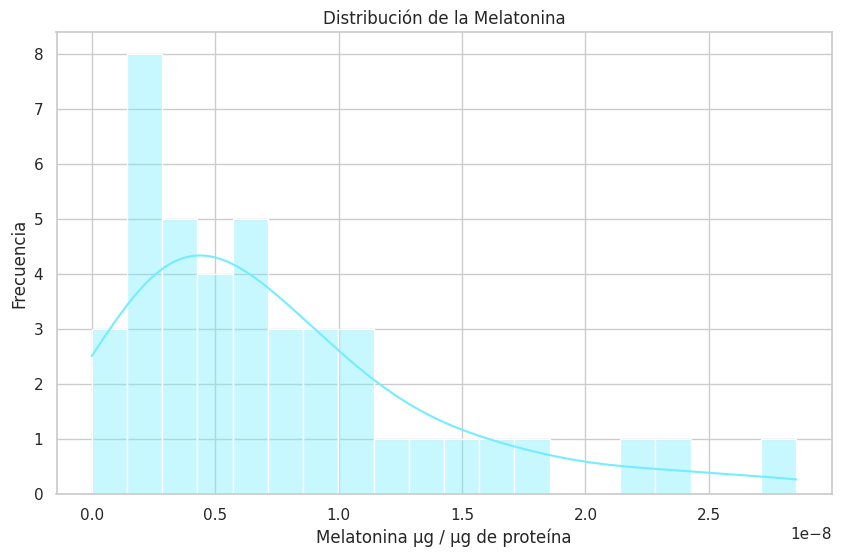

In [95]:
# Configuramos el estilo de los gráficos
sns.set_theme(style="whitegrid")

# Creamos para melatonina
plt.figure(figsize=(10, 6))
sns.histplot(df_salivas['Melatonin NORM'], bins=20, kde=True, color='#73EDFF', alpha=0.4)
plt.title('Distribución de la Melatonina')
plt.xlabel('Melatonina μg / μg de proteína')
plt.ylabel('Frecuencia')
plt.show()

Se observa una distribución asimétrica a la derecha, lo que indica que hay valores altos de melatonina en saliva. Los valores más frecuentes están entre $0.0 \times 10^{-8}$ y $0.5 \times 10^{-8}$, alcanzando valores de hasta $2.86 \times 10^{-8}$ μg de melatonina por μg de proteína. Al igual que antes, analizaremos si hay diferencias entre los valores antes de dormir y después de levantarse.


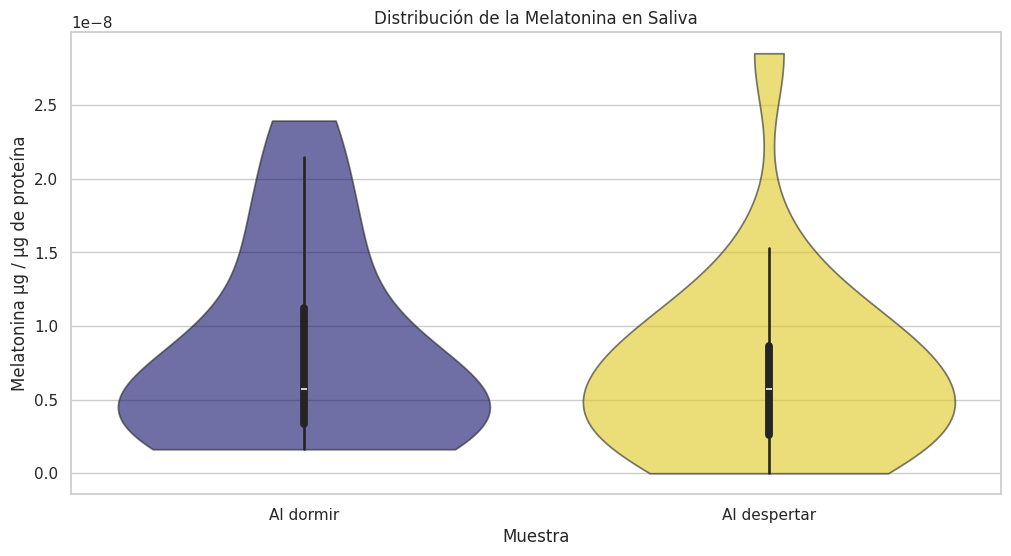

In [96]:
# Configuramos el estilo de los gráficos
sns.set_theme(style="whitegrid")

# Se crea un violin plot para visualizar la distribución del cortisol en saliva en función de la toma de la muestra
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_salivas, x='SAMPLES', y='Melatonin NORM', hue='SAMPLES', palette=['#000078', '#FFE000'], alpha=0.6, inner='box', cut=0)
plt.title('Distribución de la Melatonina en Saliva')
plt.xlabel('Muestra')
plt.ylabel('Melatonina μg / μg de proteína')
plt.xticks(ticks=[0, 1], labels=['Al dormir', 'Al despertar'])
plt.show()

A diferencia del caso anterior, no vemos una diferencia clara en la distribución de la melatonina en saliva entre la toma de la muestra antes de dormir y al despertar. Sin embargo, vamos a realizar el test de normalidad para poder determinar qué test estadístico utilizar para analizar si hay una diferencia significativa entre los niveles de melatonina antes de dormir y al despertar.

In [97]:
# Se separan los datos de melatonina en función de la toma de la muestra
melatonin_before_sleep = df_salivas[df_salivas['SAMPLES'] == 'before sleep']['Melatonin NORM']
melatonin_wake_up = df_salivas[df_salivas['SAMPLES'] == 'wake up']['Melatonin NORM']

# Se realiza el test de normalidad de Shapiro-Wilk
stat_before_sleep, p_before_sleep = shapiro(melatonin_before_sleep)
stat_wake_up, p_wake_up = shapiro(melatonin_wake_up)

# Se imprimen los resultados
print(f"Antes de dormir: Estadístico={stat_before_sleep}, p-value={p_before_sleep}")
print(f"Al despertar: Estadístico={stat_wake_up}, p-value={p_wake_up}")

Antes de dormir: Estadístico=0.8577350007531959, p-value=0.00579010807059497
Al despertar: Estadístico=0.8221193572173348, p-value=0.0014584246068405934


Para ambos casos, el p-valor es menor que 0.05, por lo que se rechaza la hipótesis nula y se concluye que los datos no siguen una distribución normal. Seguidamente se usará el test de Wilcoxon (no paramétrico) para comparar los datos.

In [98]:
# Se realiza el test de Wilcoxon
stat, p = wilcoxon(melatonin_before_sleep, melatonin_wake_up)

# Se imprimen los resultados
print(f"Estadístico={stat}, p-value={p}")

# Si el p-valor es menor que 0.05, se rechaza la hipótesis nula
if p < 0.05:
    print("Se rechaza la hipótesis nula. Hay diferencias significativas entre los niveles de melatonina antes de dormir y al despertar.")
else:
    print("No se rechaza la hipótesis nula. No hay diferencias significativas entre los niveles de melatonina antes de dormir y al despertar.")

Estadístico=86.0, p-value=0.32045745849609375
No se rechaza la hipótesis nula. No hay diferencias significativas entre los niveles de melatonina antes de dormir y al despertar.


Como se apreciaba en el gráfico de violín, los niveles de melatonina en saliva antes de dormir y al despertar son muy similares. Esto se confirma con el test de Wilcoxon, que no muestra diferencias significativas entre los niveles de melatonina antes de dormir y al despertar. Por lo que no se puede afirmar que las distribuciones de melatonina en saliva sean diferentes en función de la toma de la muestra. No obstante esto no quiere decir que no haya diferencias en los niveles de melatonina entre los usuarios, para eso se procede a calcular la diferencia de melatonina para cada usuario.

,User,Cortisol_diff,Melatonina_diff
0,user_1,0.043802,-1.063595e-08
1,user_2,0.240065,1.177563e-08
2,user_3,0.031657,-2.111115e-09
3,user_4,0.017952,-1.344186e-08
4,user_5,0.067206,-1.299462e-08
5,user_6,0.066849,-2.896914e-09
6,user_7,0.036868,2.012434e-09
7,user_8,0.051331,4.858282e-10
8,user_9,0.054592,1.792650e-09
9,user_10,-0.017387,-6.095816e-09


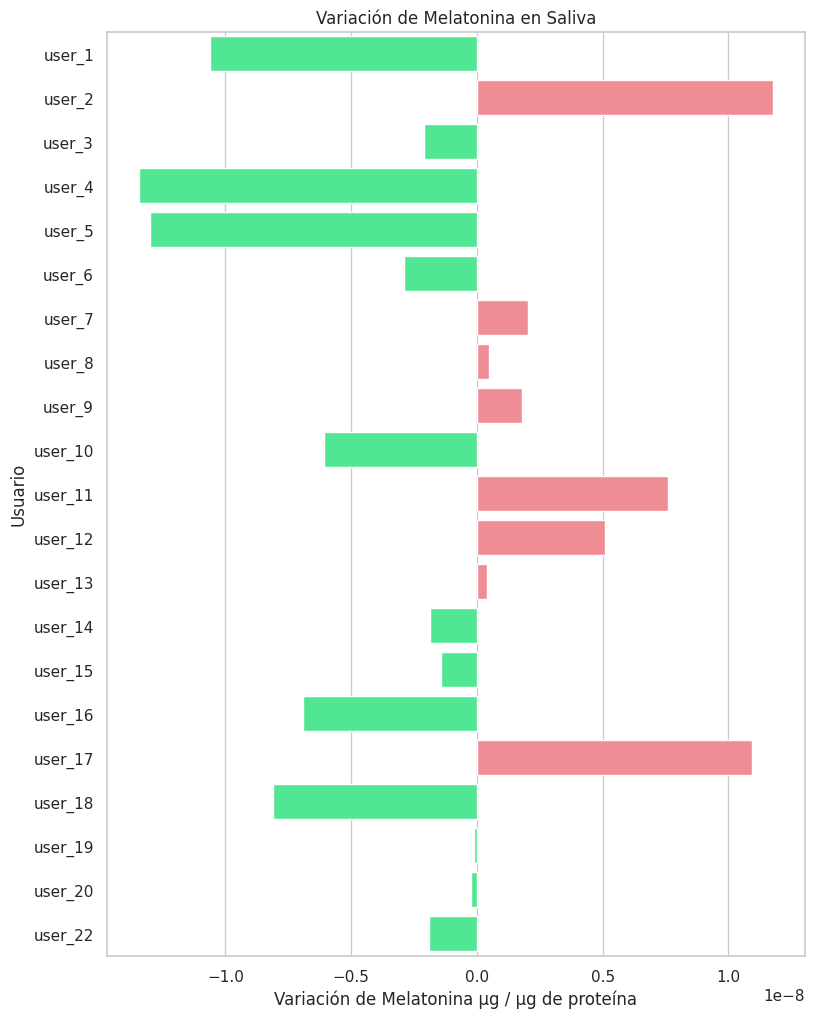

In [99]:
# Calculamos la diferencia de cortisol para cada usuario
df_saliva_diff['Melatonina_diff'] = df_saliva_diff['User'].apply(lambda x: get_hormon_diff(x, 'Melatonin NORM'))
display(df_saliva_diff)

# Se plotea un gráfico de barras con las variaciones por usuario girado 90º
plt.figure(figsize=(9, 12))
sns.barplot(data=df_saliva_diff, x='Melatonina_diff', y='User', orient='h', hue='User',
            palette=['#38FF90' if x < 0 else '#FF7D87' for x in df_saliva_diff['Melatonina_diff']])
plt.title('Variación de Melatonina en Saliva')
plt.xlabel('Variación de Melatonina μg / μg de proteína')
plt.ylabel('Usuario')
plt.show()


Aunque en las distribuciones no se observan diferencias significativas, se puede observar que la melatonina tiene una mayor variabilidad en los niveles de melatonina antes de dormir y al despertar en comparación con el cortisol. Observamos que 6 individuos presentan una diferencia negativa, lo que quiere decir que los valores de melatonina han disminuido durante la noche en el order de $-0.75 \times 10^{-8}$, lo que es un comportamiento esperado. Por otro lado 4 individuos presentan una diferencia positiva  $+0.8 \times 10^{-8}$, lo que indica que los valores de melatonina han aumentado durante la noche. El resto de individuos presentan una diferencia cercana a 0.

Se procede a realizar un gráfico de dispersión conectado con los niveles de melatonina de cada usuario antes de dormir y al despertar.

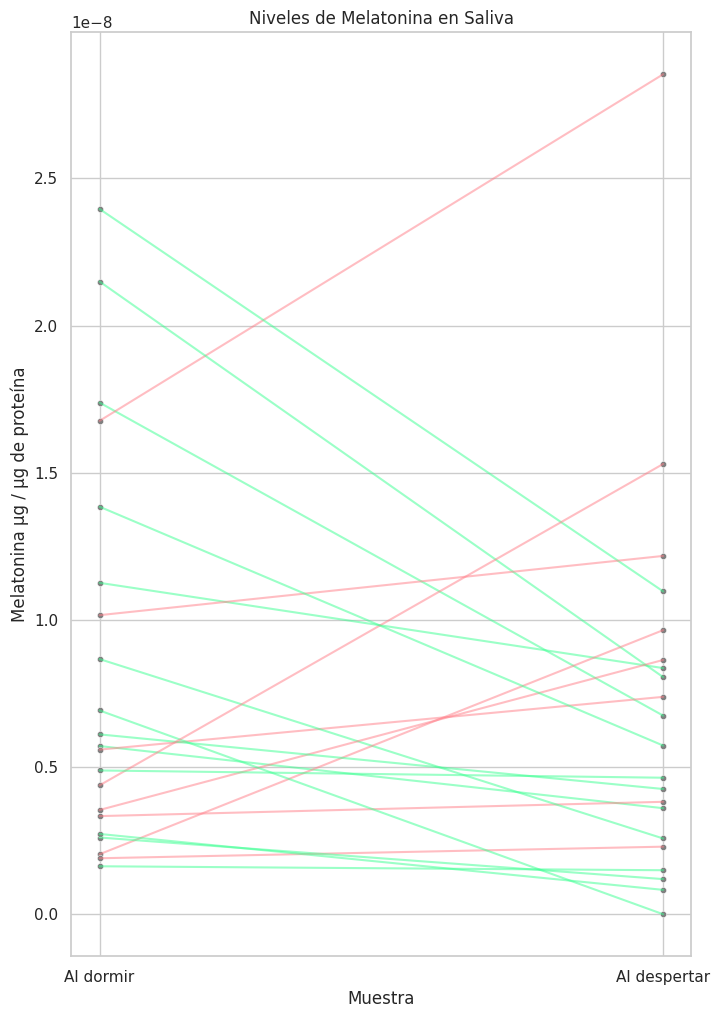

In [100]:
df_temp = pd.DataFrame({
    'User': df_saliva_diff['User'],
    'Melatonin_before_sleep': melatonin_before_sleep.values,
    'Melatonin_wake_up': melatonin_wake_up.values
})

# Crear un gráfico de dispersión conectado con los niveles de melatonina de cada usuario antes de dormir y al despertar
plt.figure(figsize=(8, 12))

# Dibujar los puntos de antes de dormir y al despertar
sns.scatterplot(x=[0]*len(df_temp), y=df_temp['Melatonin_before_sleep'], color='gray', s=20, legend=False)
sns.scatterplot(x=[1]*len(df_temp), y=df_temp['Melatonin_wake_up'], color='gray', s=20, legend=False)

# Conectar los puntos con colores específicos
for i in range(len(df_temp)):
    if df_temp['Melatonin_wake_up'].iloc[i] > df_temp['Melatonin_before_sleep'].iloc[i]:
        color = '#FF7D87'
    elif df_temp['Melatonin_wake_up'].iloc[i] < df_temp['Melatonin_before_sleep'].iloc[i]:
        color = '#38FF90'
    else:
        color = 'gray'
    plt.plot([0, 1], [df_temp['Melatonin_before_sleep'].iloc[i], df_temp['Melatonin_wake_up'].iloc[i]], color=color, alpha=0.5)

plt.title('Niveles de Melatonina en Saliva')
plt.xlabel('Muestra')
plt.ylabel('Melatonina μg / μg de proteína')
plt.xticks(ticks=[0, 1], labels=['Al dormir', 'Al despertar'])

plt.show()


Se advierte que 8 usuarios se despiertan con niveles de melatonina más altos que los que tenían antes de dormir. Aunque estos incrementos son significativos en solo 4 casos, en los otros el incremento es muy comedido. El resto de usuarios presentan disminuciones, aunque diferenciamos 2 grupos: uno de disminuciones muy leves y otro de disminuciones más significativas.

Seguidamente, se normalizan los valores de melatonina para poder comparar las variaciones entre los usuarios al despertar y antes de dormir igual que se hizo con el cortisol.

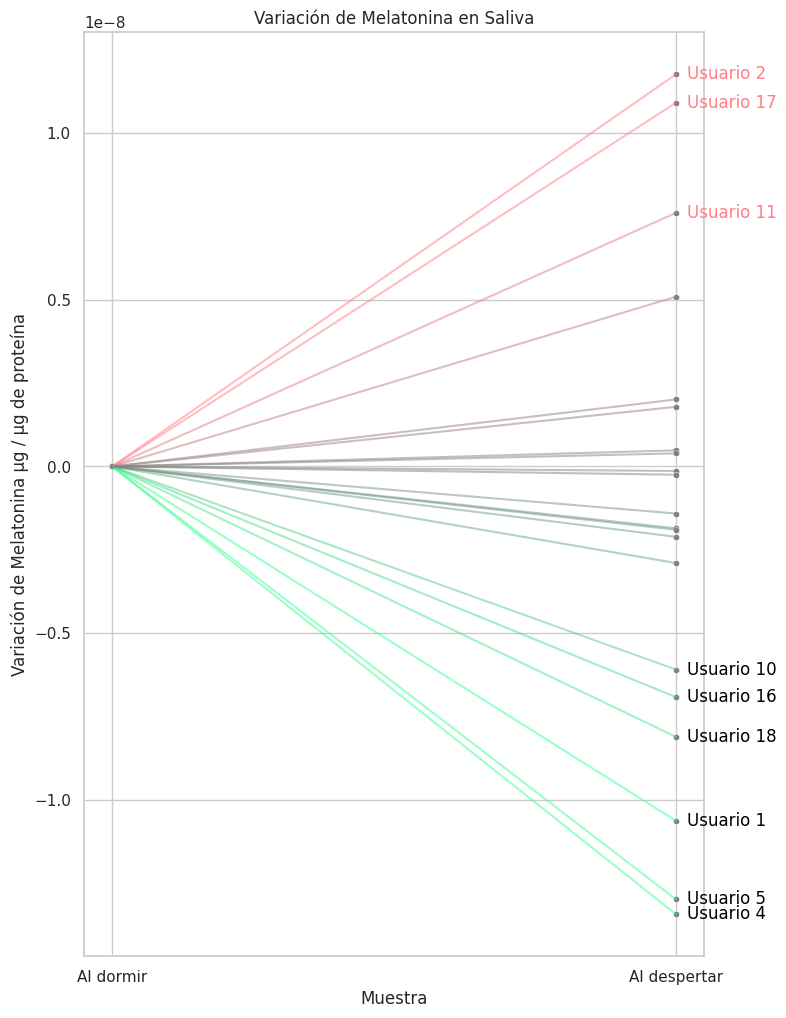

In [101]:
# Crear un df con los datos de melatonina de antes de dormir y al despertar
df_temp_norm = pd.DataFrame({
    'User': df_saliva_diff['User'],
    'Melatonin_before_sleep': melatonin_before_sleep.values,
    'Melatonin_wake_up': melatonin_wake_up.values
})

# Normalizar los valores de melatonina
df_temp_norm['Melatonin_wake_up_norm'] = df_temp_norm['Melatonin_wake_up'] - df_temp_norm['Melatonin_before_sleep']
df_temp_norm['Melatonin_before_sleep'] = 0

# Crear el gráfico de dispersión conectado con los niveles de melatonina normalizados
plt.figure(figsize=(8, 12))

# Dibujar los puntos de antes de dormir y al despertar
sns.scatterplot(x=[0]*len(df_temp_norm), y=df_temp_norm['Melatonin_before_sleep'], color='gray', s=20, legend=False)
sns.scatterplot(x=[1]*len(df_temp_norm), y=df_temp_norm['Melatonin_wake_up_norm'], color='gray', s=20, legend=False)

# Definir los colores personalizados invertidos
colors = ['#38FF90', 'gray', '#FF7D87']
cmap = LinearSegmentedColormap.from_list('custom', colors, N=256)
norm = TwoSlopeNorm(vmin=-1e-8, vcenter=0, vmax=1e-8)

# Conectar los puntos con colores específicos
for i in range(len(df_temp_norm)):
    color = cmap(norm(df_temp_norm['Melatonin_wake_up_norm'].iloc[i]))
    plt.plot([0, 1], [df_temp_norm['Melatonin_before_sleep'].iloc[i], df_temp_norm['Melatonin_wake_up_norm'].iloc[i]], color=color, alpha=0.5)

plt.title('Variación de Melatonina en Saliva')
plt.xlabel('Muestra')
plt.ylabel('Variación de Melatonina μg / μg de proteína')
plt.xticks(ticks=[0, 1], labels=['Al dormir', 'Al despertar'])

# Añadir un texto a los usuarios con variaciones negativas para identificarlos a la derecha de los puntos de al despertar
for i in range(len(df_temp_norm)):
    user_pretty = pretty_user_text(df_temp_norm['User'].iloc[i])
    y_value = df_temp_norm['Melatonin_wake_up_norm'].iloc[i]
    # Si la variación tiene una diferencia mayor a 0.5e-8, se añade un texto a la derecha de los puntos de al despertar
    if df_temp_norm['Melatonin_wake_up_norm'].iloc[i] > 0.6e-8:
        plt.text(1.02, y_value, user_pretty, ha='left', va='center', color='#FF7D87')
    # Si la variación tiene una diferencia menor a -0.5e-8, se añade un texto a la derecha de los puntos de al despertar
    if df_temp_norm['Melatonin_wake_up_norm'].iloc[i] < -0.6e-8:
        plt.text(1.02, y_value, user_pretty, ha='left', va='center', color='black')

plt.show()


Al mostrar en el gráfico las diferencias de melatonina al despertar y antes de dormir, se observa que la mayoría de los usuarios tienen una variación positiva cercana a 0. Seis usuarios tienen una variación negativa, lo que indica que tienen menos melatonina al despertar que antes de dormir, siendo esto el comportamiento esperado. Por otro lado, se encuentran hasta cuatro usuarios que tienen una variación positiva muy alta, lo que indica que tienen más melatonina al despertar que antes de dormir, pudiendo esto ser indicador de un desajuste en el ritmo circadiano. Al cruzar los datos hormonales con los datos de sueño, se podrá tener una idea más clara de si estos indican una correlación entre calidad del sueño, eficiencia y niveles de melatonina.

# 2. Guardamos el dataframe como un fichero pickle

Se construye un dataframe en formato wide con los datos de cortisol y melatonina. De manera que este tendrá las variables: 'User', 'Cortisol_before_sleep', 'Cortisol_wake_up', 'Cortisol_diff', 'Melatonin_before_sleep', 'Melatonin_wake_up', 'Melatonin_diff'.

In [102]:
df_saliva_wide = df_salivas.pivot(index='User', columns='SAMPLES', values=['Cortisol NORM', 'Melatonin NORM'])
df_saliva_wide = df_saliva_wide.droplevel(0, axis=1)
df_saliva_wide.columns = ['Cortisol_before_sleep', 'Cortisol_wake_up', 'Melatonin_before_sleep', 'Melatonin_wake_up']
df_saliva_wide.reset_index(inplace=True)

# Se calcula la diferencia de cortisol y melatonina para cada usuario
df_saliva_wide['Cortisol_diff'] = df_saliva_wide.apply(lambda x: x['Cortisol_wake_up'] - x['Cortisol_before_sleep'], axis=1)
df_saliva_wide['Melatonin_diff'] = df_saliva_wide.apply(lambda x: x['Melatonin_wake_up'] - x['Melatonin_before_sleep'], axis=1)

# Reordenamos las columnas
df_saliva_wide = df_saliva_wide[['User', 'Cortisol_before_sleep', 'Cortisol_wake_up', 'Cortisol_diff', 'Melatonin_before_sleep', 'Melatonin_wake_up', 'Melatonin_diff']]

# Reordenamos las filas en función del id del usuario
df_saliva_wide['User_num'] = df_saliva_wide['User'].str.extract('(\d+)').astype(int)
df_saliva_wide.sort_values(by='User_num', inplace=True)
df_saliva_wide.drop(columns='User_num', inplace=True)
df_saliva_wide.reset_index(drop=True, inplace=True)

# Visualizamos el df
display(df_saliva_wide)

,User,Cortisol_before_sleep,Cortisol_wake_up,Cortisol_diff,Melatonin_before_sleep,Melatonin_wake_up,Melatonin_diff
0,user_1,0.034137,0.077939,0.043802,1.738385e-08,6.747893e-09,-1.063595e-08
1,user_2,0.021186,0.261252,0.240065,1.676342e-08,2.853905e-08,1.177563e-08
2,user_3,0.012142,0.043799,0.031657,5.714439e-09,3.603324e-09,-2.111115e-09
3,user_4,0.023772,0.041724,0.017952,2.149747e-08,8.055610e-09,-1.344186e-08
4,user_5,0.022310,0.089516,0.067206,2.396239e-08,1.096777e-08,-1.299462e-08
5,user_6,0.015039,0.081888,0.066849,1.126009e-08,8.363179e-09,-2.896914e-09
6,user_7,0.020206,0.057075,0.036868,1.016154e-08,1.217397e-08,2.012434e-09
7,user_8,0.035106,0.086437,0.051331,3.334482e-09,3.820310e-09,4.858282e-10
8,user_9,0.025968,0.080560,0.054592,5.593342e-09,7.385992e-09,1.792650e-09
9,user_10,0.037046,0.019659,-0.017387,8.669611e-09,2.573795e-09,-6.095816e-09


Seguidamente, se procede a guardar el dataframe en un archivo pickle.

In [103]:
out_folder = os.path.join('..', '0_data', "clean_MMASH")
filename = 'saliva_clean.pkl'

# Comprobamos si la carpeta existe, si no la creamos
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

# Comprobamos si el archivo existe, de ser así lo eliminamos
if os.path.exists(os.path.join(out_folder, filename)):
    os.remove(os.path.join(out_folder, filename))

# Guardamos el df en un archivo pickle
df_saliva_wide.to_pickle(os.path.join(out_folder, filename))

# Bibliografía

[1] Rossi, A., Da Pozzo, E., Menicagli, D., Tremolanti, C., Priami, C., Sîrbu, A., Clifton, D. A., Martini, C., & Morelli, D. (2020). A Public Dataset of 24-h Multi-Levels Psycho-Physiological Responses in Young Healthy Adults. Data, 5(4), 91. https://doi.org/10.3390/data5040091

[2] Yap, Y., Tung, N., Shen, L., Bei, B., Phillips, A., & Wiley, J. (2024). Daily associations between salivary cortisol and electroencephalographic-assessed sleep: a 15-day intensive longitudinal study. Sleep, 47. https://doi.org/10.1093/sleep/zsae087.

[3] Pulopulos, M., Hidalgo, V., Puig-Perez, S., Montoliu, T., & Salvador, A. (2020). Relationship between Cortisol Changes during the Night and Subjective and Objective Sleep Quality in Healthy Older People. International Journal of Environmental Research and Public Health, 17. https://doi.org/10.3390/ijerph17041264.

[4] Poza, J. J., Pujol, M., Ortega-Albás, J. J., & Romero, O. (2022). Melatonina en los trastornos de sueño. In Neurología (Vol. 37, Issue 7, pp. 575–585). Elsevier BV. https://doi.org/10.1016/j.nrl.2018.08.002